In [1]:
import os; os.chdir("..")

In [2]:
%load_ext autoreload
# %load_ext juypter_black
%autoreload 2
%matplotlib inline

In [3]:
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urbanstats.games.quiz_analysis import get_full_statistics, questions
from urbanstats.games.quiz_question_distribution import compute_difficulty, RANGES
from urbanstats.games.quiz_columns import stat_to_quiz_name
from urbanstats.games.quiz import (
    display_question,
    renamed,
)
from urbanstats.statistics.output_statistics_metadata import internal_statistic_names

/home/kavi/anaconda3/envs/urbanstats-310/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [4]:
text_to_col = {q : k for k, q in stat_to_quiz_name().items()}
text_to_col.update(renamed)
text_to_col = {k.lower(): v for k, v in text_to_col.items()}
text_to_col.update({k.split("!tooltip")[0].strip(): v for k, v in text_to_col.items()})

bad = set(text_to_col.values()) - set(internal_statistic_names())
assert not bad, bad

In [5]:
 # plt.rcParams["font.family"] = "monospace"

In [6]:
result = get_full_statistics(after_problem=1, debug=False)
num_users_by_problem = result.groupby("problem").count().user_id
means = result[["problem", "score", *questions]].groupby("problem").mean()

/home/kavi/anaconda3/envs/urbanstats-310/lib/python3.10/site-packages/pandas/core/tools/datetimes.py:528: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


In [7]:
qdata = []
for problem in means.index:
    with open(f"/home/kavi/temp/site/quiz/{problem}") as f:
        quiz_qns = json.load(f)
    for qcol, q in zip(questions, quiz_qns):
        qn = q["question"].lower()
        qn = qn.split("!tooltip")[0].strip()
        if "dewpoint" in qn or "hawaiian" in qn or "native" in qn.lower() or "area" in qn:
            continue
        sl, sh = q["stat_a"], q["stat_b"]
        if sl > sh:
            sh, sl = sl, sh
        if qn not in text_to_col:
            print(repr(qn))
            continue
        qdata.append(dict(
            a=q["longname_a"],
            b=q["longname_b"],
            error_rate=1-means.loc[problem, qcol],
            col=text_to_col[qn],
            stat_high=sh,
            stat_low=sl,
            quiz_number=problem,
            question_index=int(qcol[1:])
        ))
qdata = pd.DataFrame(qdata)

/home/kavi/anaconda3/envs/urbanstats-310/lib/python3.10/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


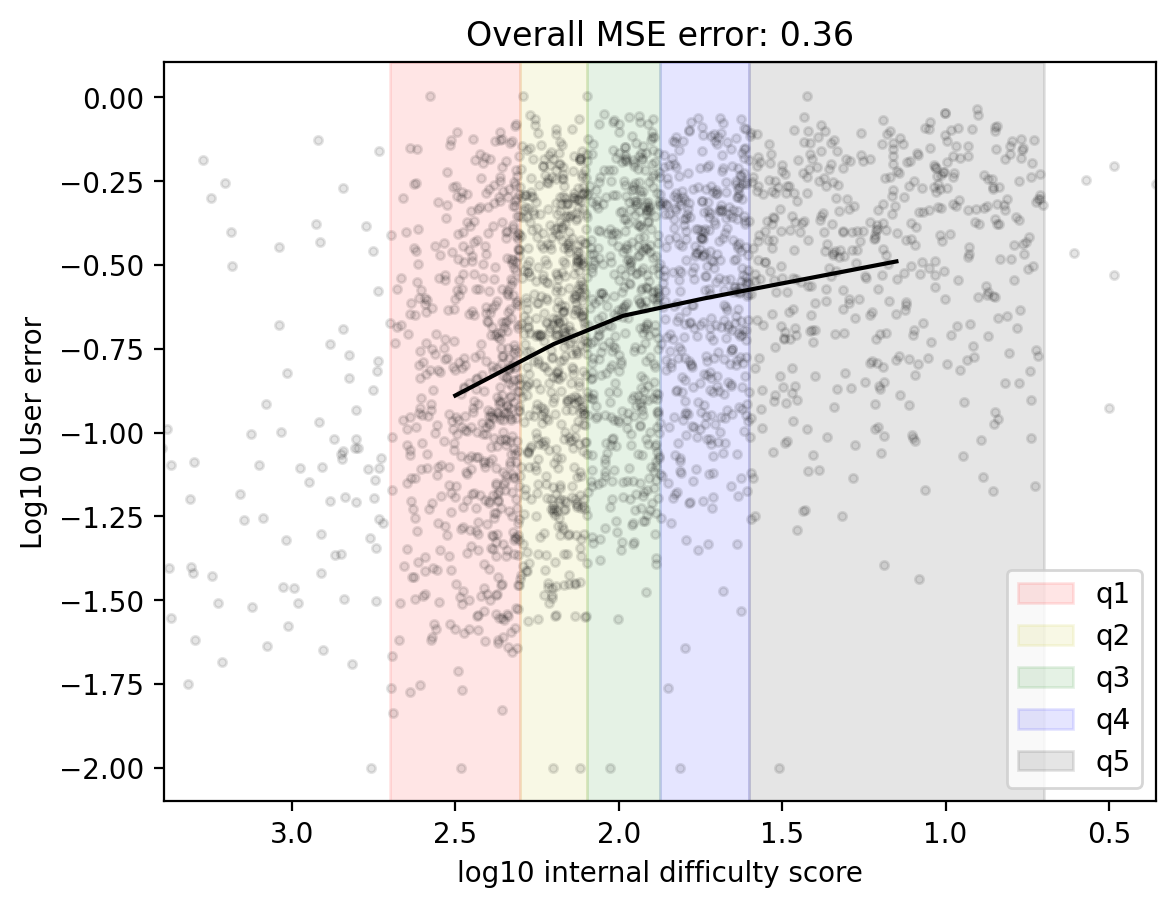

In [8]:
qdata["log_diff"] = np.log(qdata.stat_high / qdata.stat_low)
qdata["pct_diff"] = qdata.stat_high / qdata.stat_low - 1
# qdata["cat"] = qdata.col.apply(lambda x: get_statistic_categories()[x])
qdata["diffi"] = qdata.apply(lambda row: compute_difficulty(row.stat_high, row.stat_low, row.col, row.a, row.b), axis=1)

plt.figure(dpi=200, facecolor="white")
x, y = np.log10(qdata.diffi), np.log10(qdata.error_rate + 1e-2)
bucket_loc = []
ease_each = []
delta = []
err_total = 0
qdata["delta"] = np.nan
qdata["question_index_imputed"] = 0
rs = [list(x) for x in RANGES]
for i, (lo, hi) in enumerate(rs):
    mask = (np.log10(lo) < x) & (x <= np.log10(hi))
    ease_each.append(y[mask].mean())
    bucket_loc.append((np.log10(lo) + np.log10(hi)) / 2)
    delta.append(y[mask] - ease_each[-1])
    qdata.loc[mask, "delta"] = delta[-1]
    qdata.loc[mask, "question_index_imputed"] = i + 1
    err_total += (delta[-1] ** 2).sum()
    plt.axvspan(np.log10(lo), np.log10(hi), alpha=0.1, color="rygbk"[i], label=f"q{i+1}")
err_total = (err_total / y.shape[0]) ** 0.5
plt.scatter(x, y, alpha=0.1, marker=".", color="black")
plt.plot(bucket_loc, ease_each, color="black")
#     plt.plot(xs, ys)
plt.xlabel("log10 internal difficulty score")
plt.xlim(np.percentile(x, [99, 0]))
plt.ylabel("Log10 User error")
plt.title(f"Overall MSE error: {err_total:.2f}")
plt.legend()
plt.show()

(m, b), *_ = np.linalg.lstsq(np.array([x, np.ones_like(x)]).T, y, rcond=None)
qdata["residuals"] = y - (m * x + b)

In [9]:
qdata_recent = qdata[qdata.quiz_number > 300]
qdata_recent.pivot_table(index="question_index", columns="question_index_imputed", aggfunc='count')["a"].fillna(0).astype(int)

question_index_imputed,0,1,2,3,4,5
question_index,,,,,,
1,15,167,0,2,0,0
2,4,21,155,0,0,0
3,7,28,32,113,0,0
4,6,5,14,20,137,0
5,1,3,1,5,14,160


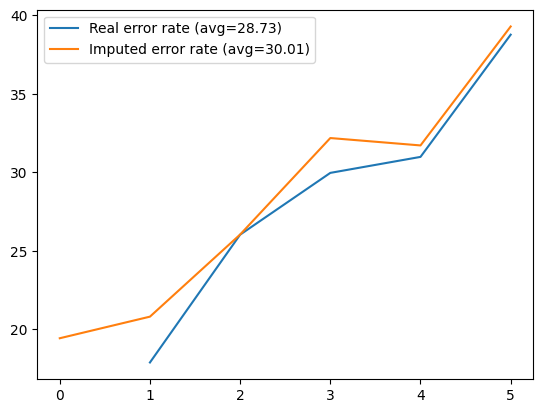

In [10]:
error_rate_real = 100 * qdata_recent.groupby("question_index").mean().error_rate
error_rate_imputed = 100 * qdata_recent.groupby("question_index_imputed").mean().error_rate

plt.plot(error_rate_real, label=f"Real error rate (avg={error_rate_real.mean():.2f})")
plt.plot(error_rate_imputed, label=f"Imputed error rate (avg={error_rate_imputed[error_rate_imputed.index != 0].mean():.2f})")
plt.legend()

In [11]:
agg = qdata[["col", "residuals"]].groupby("col").agg(["mean", "count"])
agg["abs_mean"] = np.abs(agg[('residuals', 'mean')])
agg = agg[agg['residuals', 'count'] > 10].sort_values("abs_mean")
for x in [*agg.index[::-1][:20]]:
    name = stat_to_quiz_name()[x].split("!TO")[0]
    if name.startswith("!FULL"):
        name = name[6:]
    else:
        name = f"Which has a {name}?"
    print(name)
    score = agg.iloc[list(agg.index).index(x)]['residuals', 'mean']
    print(f"d.r.e. {score:+.2f}: ({np.exp(score) - 1:+.0%})")

Which has a higher % of residents who are citizens by birth?
d.r.e. -0.58: (-44%)
Which has a higher % of days with wind speed over 10mph (population weighted)?
d.r.e. +0.48: (+61%)
Which has a higher mean daily high heat index (population weighted)?
d.r.e. -0.42: (-34%)
Which has less exposure to active EPA superfund sites (higher population-weighted mean distance)?
d.r.e. +0.40: (+49%)
Which has a larger % of homes heated using electricity?
d.r.e. +0.38: (+47%)
Which has a higher mean daily high temperature (population weighted)?
d.r.e. -0.35: (-29%)
Which has a higher % of people who commute by car?
d.r.e. -0.34: (-29%)
Which has a higher % of people who only speak english at home?
d.r.e. -0.34: (-29%)
Which has a higher % of people who have commute time under 15 min?
d.r.e. +0.32: (+38%)
Which has a higher % of people who were born in the US and outside their state of residence?
d.r.e. +0.32: (+37%)
Which has a higher % of people who are renters?
d.r.e. -0.30: (-26%)
Which has a hi